# Load and Visualize MgSiO3 melt Data
* Focus on classical simulations of Spera et al. (2011)
    * we only analyze simulations produced with high-pressure potential set of Oganov et al. (2000)
* Also load First Principles MD data from deKoker et al. (2009)

In [1]:
import matplotlib.pyplot as plt
%matplotlib notebook
import numpy as np
import pandas as pd
import pickle
# import emcee

import xmeos
from xmeos import models
from xmeos import datamod

import copy

In [2]:
analysis_file = 'data/analysis.pkl'
with open(analysis_file, 'rb') as f:
    analysis = pickle.load(f)
    
datasets = analysis['datasets']

In [3]:
data = datasets['deKoker2009']
# View data tables
tbl = data['table']
tbl.head()

,V,T,P,E,Verr,T_label,V_label
0,14.210892,2000,-1.058632,-7.228171,0,2000.0,14.21
1,12.918993,2000,1.302932,-7.240976,0,2000.0,12.92
2,11.627094,2000,3.583062,-7.232767,0,2000.0,11.63
3,10.335194,2000,10.097720,-7.256082,0,2000.0,10.34
4,15.502791,3000,-0.570033,-6.844948,0,3000.0,15.50


## Visualize FPMD data of deKoker et al. (2009)

In [4]:
datamodel_S11 = analysis['datamodel']
eos_mod = copy.deepcopy(datamodel_S11['eos_mod'])

datamodel = datamod.init_datamodel(data, eos_mod)

# Set colorbar temperature properties
cmap = plt.get_cmap('coolwarm',len(data['T_labels']))
delT = np.diff(data['T_labels'])[0]


dE0 = 13.75
E0 = eos_mod.get_params()['E0'] + dE0
eos_mod.set_param_values(E0,param_names='E0')

V0 = eos_mod.get_params()['V0']
Tlbl = data['T_labels']
cmap = plt.get_cmap('coolwarm',len(Tlbl))
clims = [Tlbl[0]-delT/2,Tlbl[-1]+delT/2]

Vmod = V0*np.linspace(.4,1.2,1001)

<IPython.core.display.Javascript object>


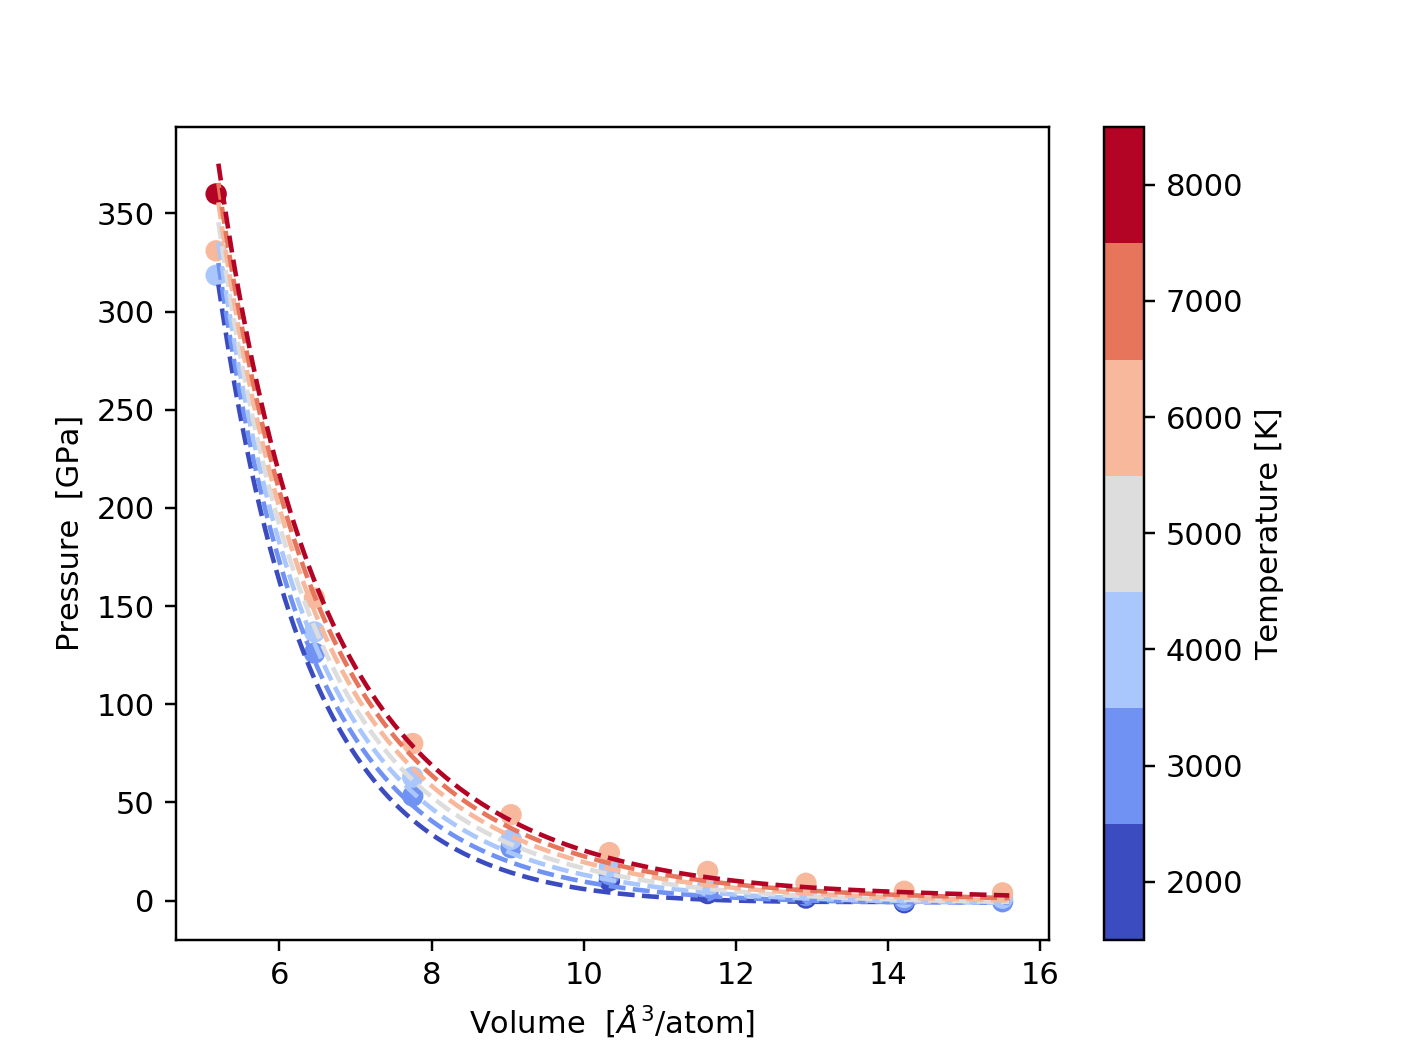

In [5]:



plt.figure()
plt.scatter(tbl['V'],tbl['P'],c=tbl['T'], cmap=cmap)

for iT in data['T_labels']:
    icol = cmap((iT-clims[0])/(clims[1]-clims[0]))
    plt.plot(Vmod, eos_mod.press(Vmod,iT),'--',color=icol)
    
plt.xlabel(r'Volume  [$\AA^3$/atom]')
plt.ylabel(r'Pressure  [GPa]')
cbar = plt.colorbar()
cbar.set_ticks(data['T_labels'])
cbar.set_label('Temperature [K]')
plt.clim(data['T_labels'][0]-delT/2,data['T_labels'][-1]+delT/2)


<IPython.core.display.Javascript object>


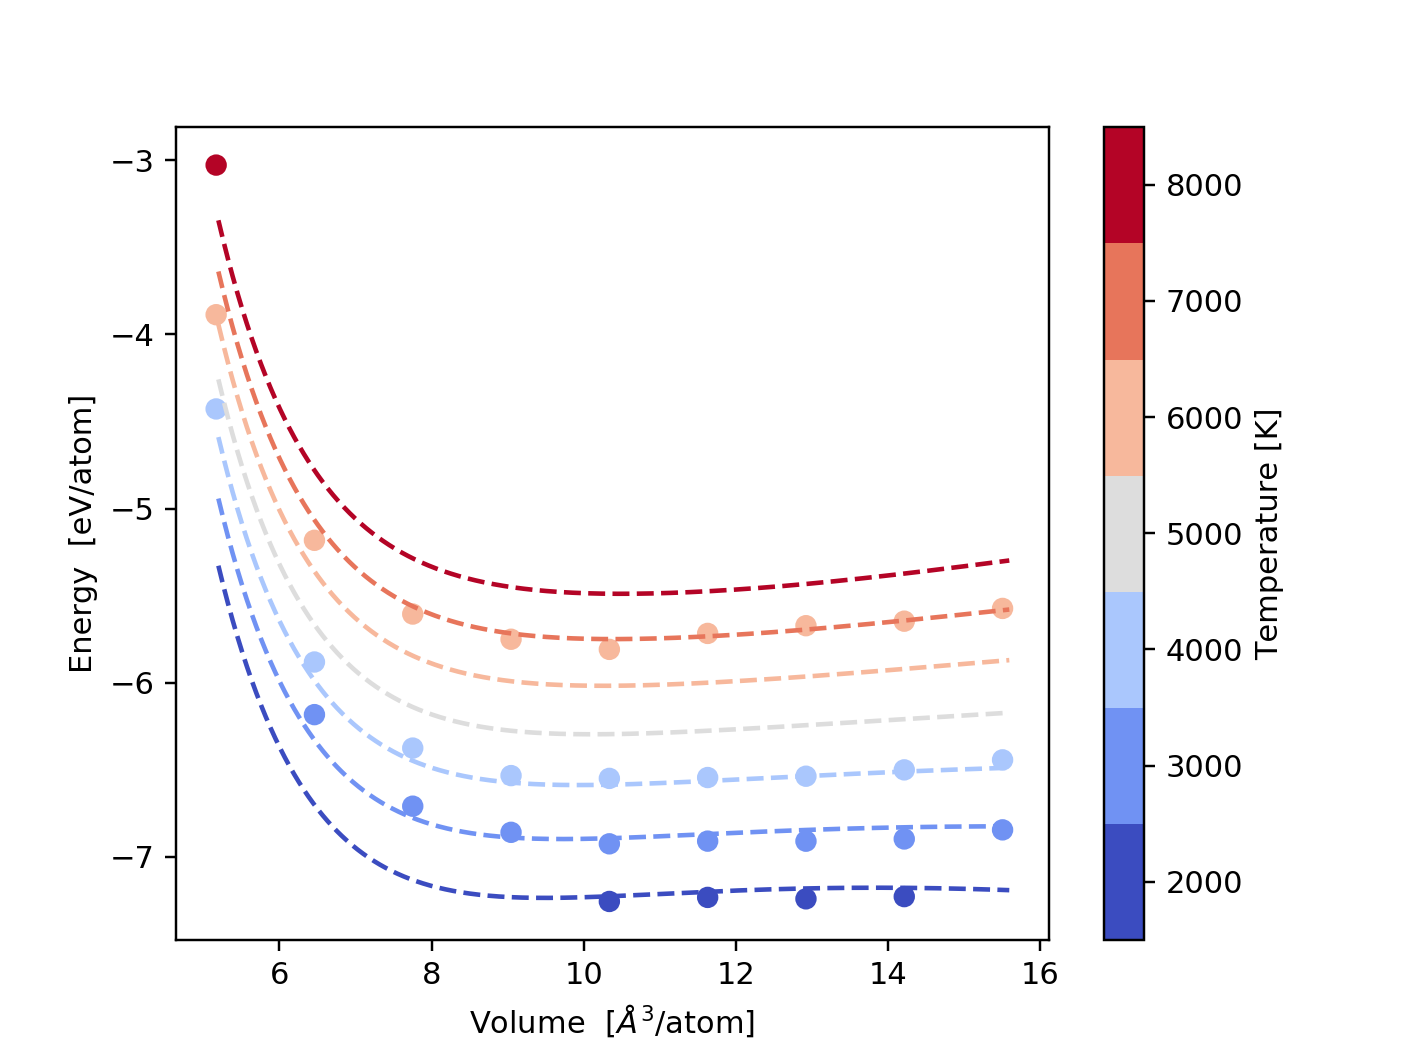

In [6]:


plt.figure()
plt.scatter(tbl['V'],tbl['E'],c=tbl['T'], cmap=cmap)


for iT in data['T_labels']:
    icol = cmap((iT-clims[0])/(clims[1]-clims[0]))
    plt.plot(Vmod, eos_mod.internal_energy(Vmod,iT),'--',color=icol)
    
plt.xlabel(r'Volume  [$\AA^3$/atom]')
plt.ylabel(r'Energy  [eV/atom]')
cbar = plt.colorbar()
cbar.set_ticks(data['T_labels'])
cbar.set_label('Temperature [K]')
plt.clim(data['T_labels'][0]-delT/2,data['T_labels'][-1]+delT/2)

<IPython.core.display.Javascript object>


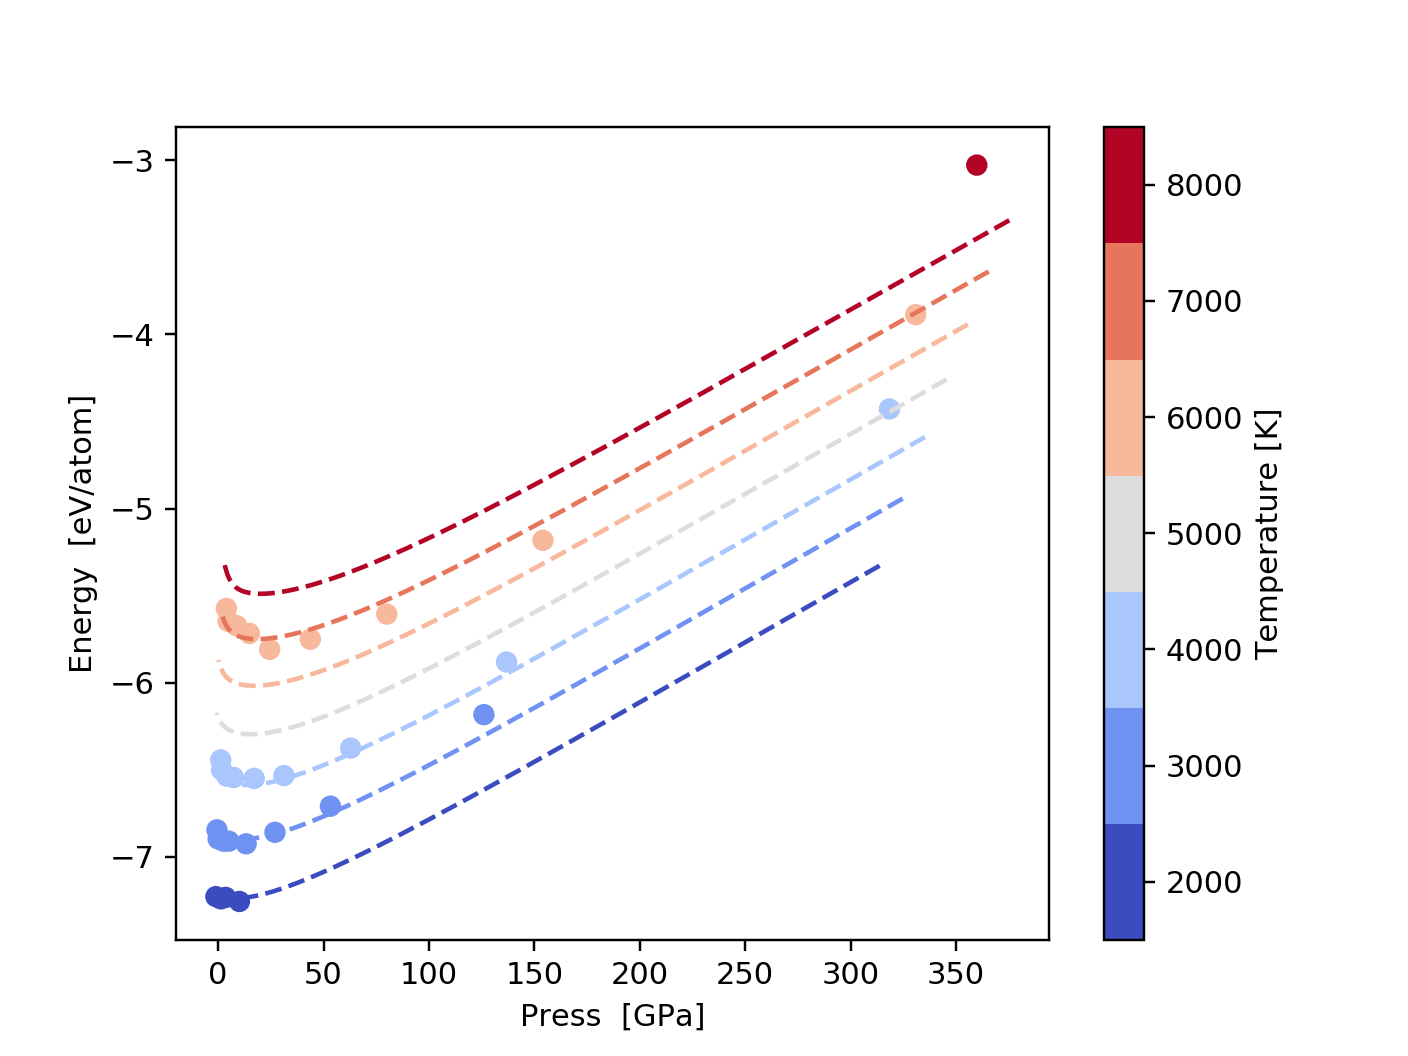

In [7]:


plt.figure()
plt.scatter(tbl['P'],tbl['E'],c=tbl['T'], cmap=cmap)


for iT in data['T_labels']:
    icol = cmap((iT-clims[0])/(clims[1]-clims[0]))
    plt.plot(eos_mod.press(Vmod,iT),eos_mod.internal_energy(Vmod,iT),'--',color=icol)
    
plt.xlabel(r'Press  [GPa]')
plt.ylabel(r'Energy  [eV/atom]')
cbar = plt.colorbar()
cbar.set_ticks(data['T_labels'])
cbar.set_label('Temperature [K]')
plt.clim(data['T_labels'][0]-delT/2,data['T_labels'][-1]+delT/2)

In [8]:
fit_calcs = ['compress','refstate','gamma','bcoef','thermal']
fix_params = ['S0','Cvlimfac','mexp']
# fix_params = ['S0','Cvlimfac']
# fix_params = ['S0','mexp']
datamodel['eos_mod'].set_param_values([3/5,1], param_names=['mexp','Cvlimfac'])

datamod.select_fit_params(datamodel, fit_calcs, fix_params=fix_params)
datamodel['fit_params']

['V0',
 'K0',
 'KP0',
 'E0',
 'gamma0',
 'gammap0',
 '_bcoef_0',
 '_bcoef_1',
 '_bcoef_2',
 '_bcoef_3',
 '_bcoef_4']

In [10]:
datamod.fit(datamodel)
datamod.fit(datamodel, apply_bulk_mod_wt=True)

In [11]:
display('R2fit = ', datamodel['posterior']['R2fit'])
display('Model Residual Error = ', datamodel['posterior']['fit_err'])
display(datamodel['posterior']['param_tbl'])

'R2fit = '

{'E': 0.99588570644740226, 'P': 0.99410536984845055, 'V': 0.99364366200892196}

'Model Residual Error = '

{'E': 0.069163694552488886, 'P': 9.5244446391592206, 'V': 0.29104793529963596}

,name,value,error
0,V0,14.771601,0.105431
1,K0,10.139120,0.817252
2,KP0,7.173988,0.208319
3,E0,-6.836346,0.018847
4,gamma0,0.278558,0.021427
5,gammap0,-0.937690,0.155816
6,_bcoef_0,1.493564,0.068918
7,_bcoef_1,0.176395,0.129379
8,_bcoef_2,2.069723,1.181961
9,_bcoef_3,15.253162,6.636736


In [28]:
from collections import OrderedDict
eos_mod = datamodel['eos_mod']
Tref = 1773
Vref = eos_mod.volume(0,Tref)
refvals = OrderedDict()
refvals['Vref'] = Vref
refvals['Kref'] = eos_mod.bulk_modulus(Vref,Tref)
refvals['Cvref'] = eos_mod.heat_capacity(Vref,Tref)/models.CONSTS['kboltz']
display(refvals)

OrderedDict([('Vref', array([ 12.77041786])),
             ('Kref', array([ 20.45734125])),
             ('Cvref', array([ 5.72831383]))])

In [11]:
# datamod.fit(datamodel, apply_bulk_mod_wt=True)

<IPython.core.display.Javascript object>


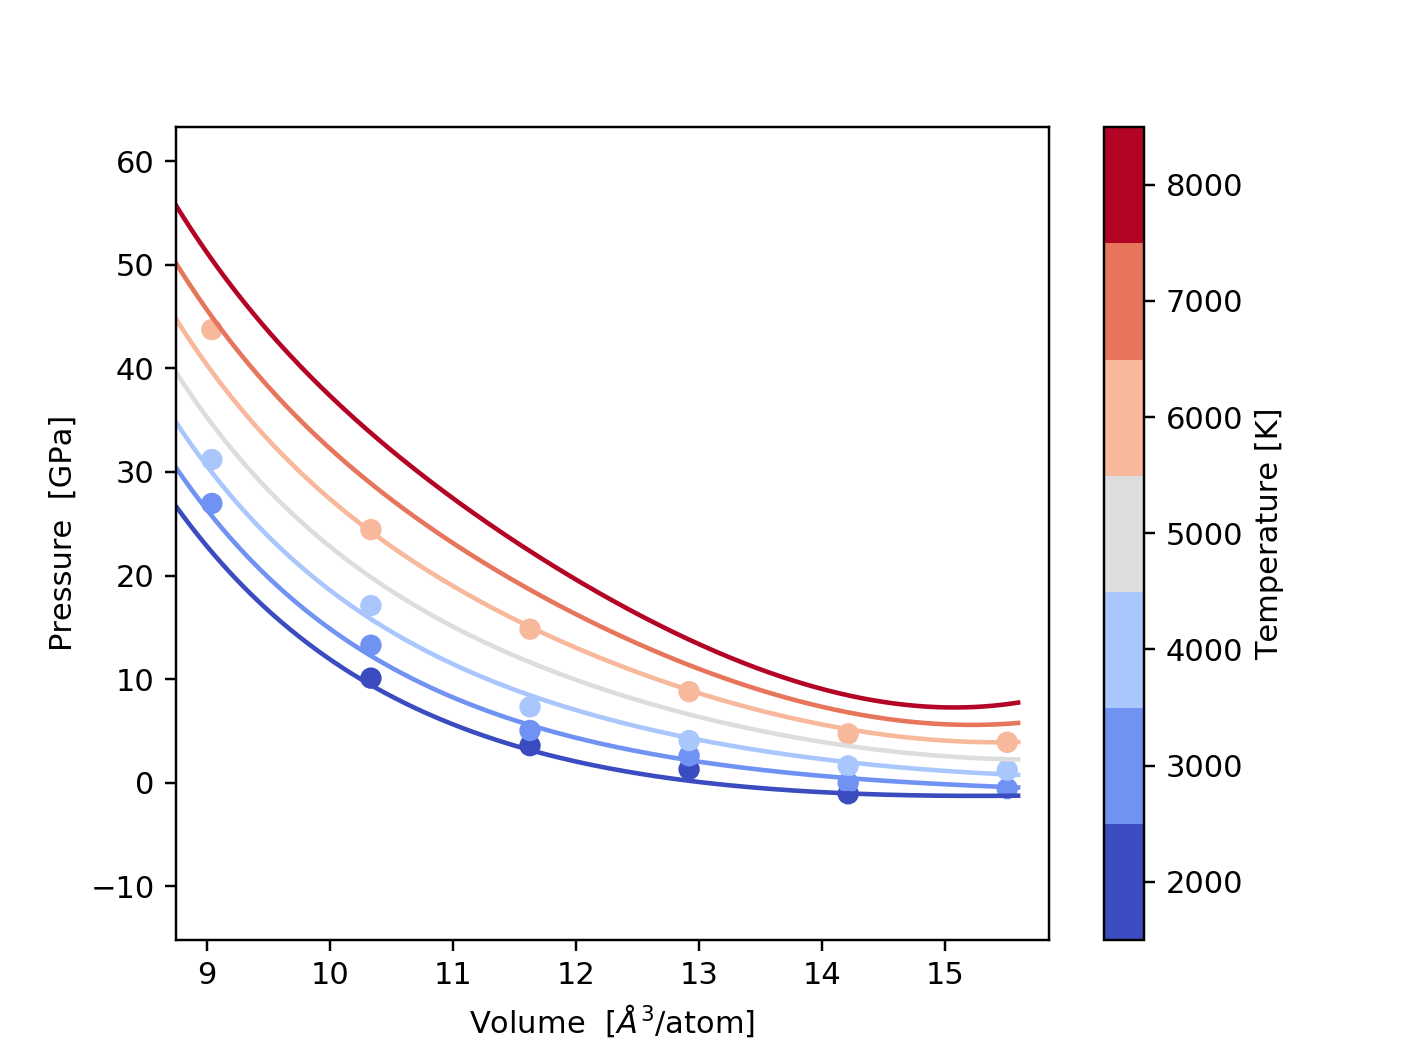

In [12]:
# Set colorbar temperature properties
cmap = plt.get_cmap('coolwarm',len(data['T_labels']))
delT = np.diff(data['T_labels'])[0]
Vmod = V0*np.linspace(.39,1.2,1001)


plt.figure()
plt.scatter(tbl['V'],tbl['P'],c=tbl['T'], cmap=cmap)

for iT in data['T_labels']:
    icol = cmap((iT-clims[0])/(clims[1]-clims[0]))
    plt.plot(Vmod, eos_mod.press(Vmod,iT),'-',color=icol)
    
plt.xlabel(r'Volume  [$\AA^3$/atom]')
plt.ylabel(r'Pressure  [GPa]')
cbar = plt.colorbar()
cbar.set_ticks(data['T_labels'])
cbar.set_label('Temperature [K]')
plt.clim(data['T_labels'][0]-delT/2,data['T_labels'][-1]+delT/2)


<IPython.core.display.Javascript object>


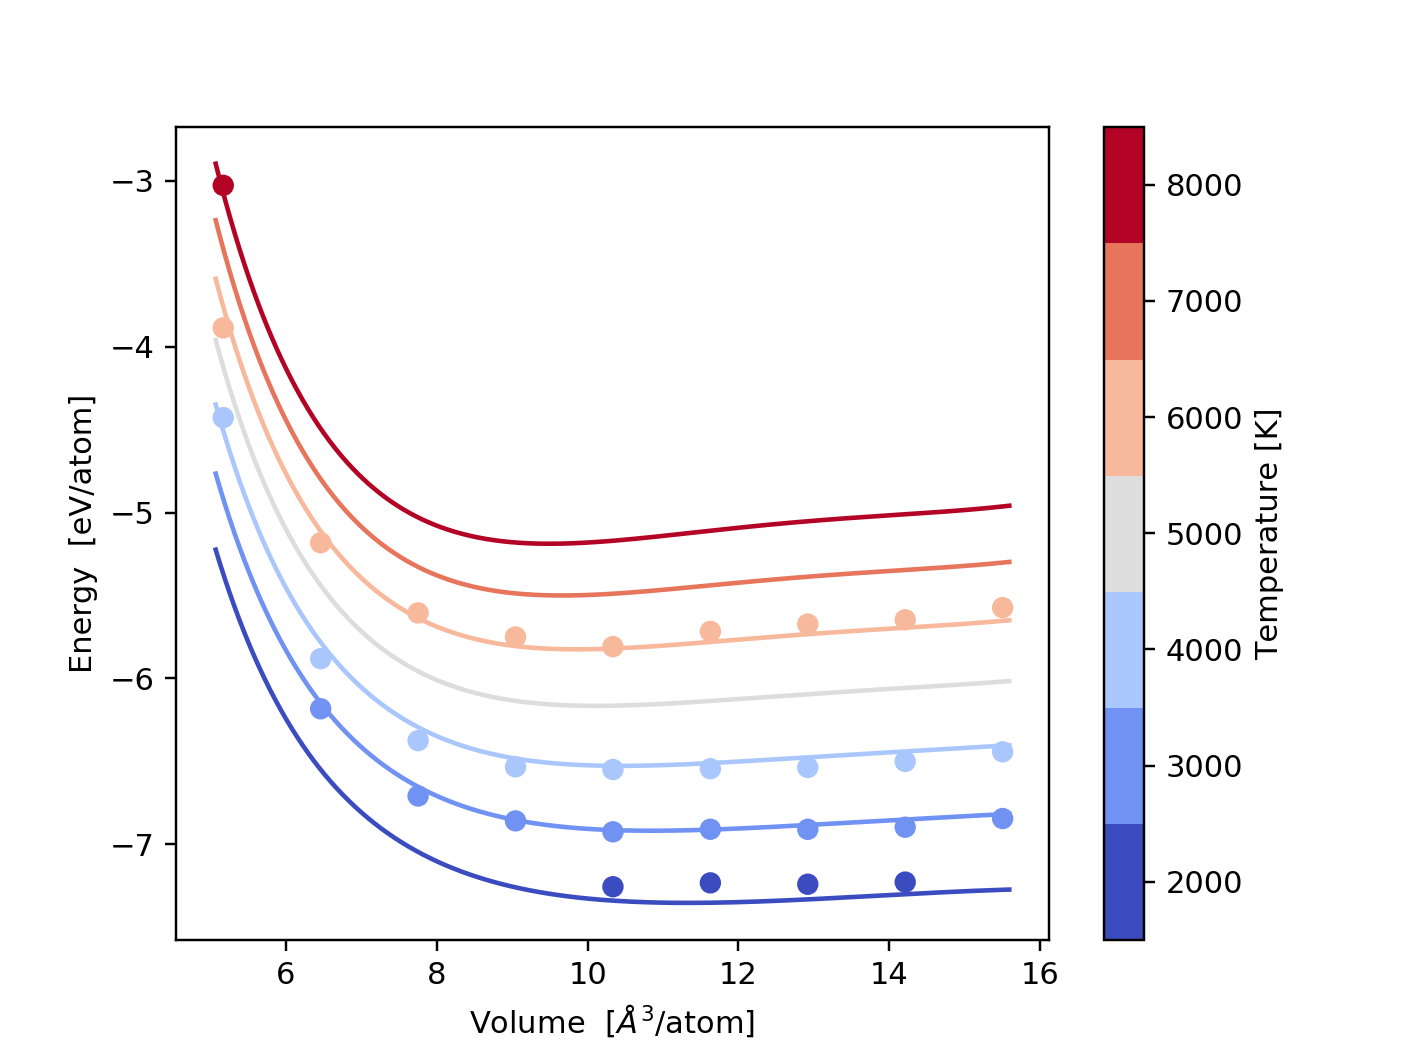

In [13]:
plt.figure()
plt.scatter(tbl['V'],tbl['E'],c=tbl['T'], cmap=cmap)


for iT in data['T_labels']:
    icol = cmap((iT-clims[0])/(clims[1]-clims[0]))
    plt.plot(Vmod, eos_mod.internal_energy(Vmod,iT),'-',color=icol)
    
plt.xlabel(r'Volume  [$\AA^3$/atom]')
plt.ylabel(r'Energy  [eV/atom]')
cbar = plt.colorbar()
cbar.set_ticks(data['T_labels'])
cbar.set_label('Temperature [K]')
plt.clim(data['T_labels'][0]-delT/2,data['T_labels'][-1]+delT/2)